# Импорты

In [3]:
# массивы, рандом
import pandas as pd
import numpy as np

# файлы
from os.path import join as pjoin
import os
import json

# модельки
import segmentation_models_pytorch as smp

# torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# аугментация
import albumentations as album

# отображение
# from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import torchvision
import torchinfo
from torch.utils.tensorboard import SummaryWriter
from board import uniqufy_path, create_image_plot

# метрики
from torchmetrics.classification import BinaryJaccardIndex

# оптимизаторы, изменение lr
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# лос
from segmentation_models_pytorch.losses import LovaszLoss, DiceLoss

# Описание

В данной работа позволяет попрактиковаться по задачам на сегментацию. Сегментация дорог по аэрофотоснимкам Препятствия из-за близлежащих деревьев, тени от соседних зданий, различная текстура и цвет дорог, дисбаланс классов дорог.

ссылка на задачу - https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset

# Константы

In [4]:
DATA_DIR = 'data/tiff/'
DATA_CLASSES = "data/label_class_dict.csv"
PRED_TEST = 'pred/test/'
PRED_VALID = 'pred/valid/'

DATA_DIR = 'data/tiff/'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Параметры

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_dict = pd.read_csv("data/label_class_dict.csv")

CLASSES = class_dict['name'].tolist()
CLASSES_RGB = class_dict[['r','g','b']].values.tolist()

print('Классы: ', CLASSES)
print('Классы RGB значений: ', CLASSES_RGB)

Классы:  ['background', 'road']
Классы RGB значений:  [[0, 0, 0], [255, 255, 255]]


# Функции

In [6]:
def print_image(**images):
    n_images = len(images)
    plt.figure(figsize=(16, 4))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis=-1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


# Классы

In [7]:
class RoadsDataset(Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

# Работа с картинками (Демо)

In [8]:
# dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=CLASSES_RGB)
# for i in range(3):
#     random_idx = random.randint(0, len(dataset)-1)
#     image, mask = dataset[random_idx]
    
#     print_image(
#         original_image = image,
#         ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), CLASSES_RGB),
#         one_hot_encoded_mask = reverse_one_hot(mask)
#     )

# Гипер-параметры

In [9]:
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_WORKERS = 0
METRIC = BinaryJaccardIndex()

MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]
SIZE_IMAGE = 256

# Преобразования

In [10]:
train_transform = album.Compose(
    [
        album.RandomCrop(height=SIZE_IMAGE, width=SIZE_IMAGE, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        album.Normalize(mean=MEAN_IMAGE_TRANSFORM, std=MEAN_IMAGE_STD, always_apply=True)
    ]
)

test_transform = album.Compose([
    album.PadIfNeeded(min_height=1536, min_width=1536,
                      always_apply=True, border_mode=0),
])

prepare_to_network = album.Lambda(image=to_tensor, mask=to_tensor)

# Параметры преобразования изображения

In [11]:
# augmented_dataset = RoadsDataset(
#     x_train_dir, y_train_dir, 
#     augmentation=train_transform,
#     class_rgb_values=CLASSES_RGB,
# )

# random_idx = random.randint(0, len(augmented_dataset)-1)

# for i in range(1):
#     image, mask = augmented_dataset[random_idx]
#     print_image(
#         original_image = image,
#         ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), CLASSES_RGB),
#         one_hot_encoded_mask = reverse_one_hot(mask)
#     )

# Модель

In [12]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = CLASSES
ACTIVATION = nn.ReLU

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [16]:
model = model.to(DEVICE)

# print(torchinfo.summary(model, input_size=(BATCH_SIZE, 3, SIZE_IMAGE, SIZE_IMAGE)))

print(model_sum := torchinfo.summary(model, input_size=(BATCH_SIZE, 3, SIZE_IMAGE, SIZE_IMAGE), row_settings=["var_names"], verbose=0, col_names=[
      "input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"]))

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
Unet (Unet)                                        [32, 3, 256, 256]         [32, 2, 256, 256]         --                             --                   --                        --                        True
├─MobileNetV2Encoder (encoder)                     [32, 3, 256, 256]         [32, 3, 256, 256]         --                             --                   --                        --                        True
│    └─Sequential (features)                       --                        --                        --                             --                   --                        --                        True
│    │    └─Conv2dNormActivation (0)               [32, 3, 256, 256]         [32, 32, 128, 128]        928                         0.01%           

# Загрузка данныъх

In [34]:
train_dataset = RoadsDataset(x_train_dir, y_train_dir,
                       class_rgb_values=CLASSES_RGB, augmentation=train_transform, preprocessing=prepare_to_network)
valid_dataset = RoadsDataset(x_valid_dir, y_valid_dir,
                       class_rgb_values=CLASSES_RGB, augmentation=test_transform, preprocessing=prepare_to_network)
test_dataset = RoadsDataset(x_test_dir, y_test_dir,
                       class_rgb_values=CLASSES_RGB, augmentation=test_transform, preprocessing=prepare_to_network)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=1,
    num_workers=0,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0,
)

# Обучение

In [35]:
from segmentation_models_pytorch.losses import LovaszLoss
# criterion = smp.utils.losses.DiceLoss()
criterion = LovaszLoss(mode='binary')

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0.00001)

scheduler = ReduceLROnPlateau(
    optimizer, 'min', patience=2)


In [36]:
def train_step(my_model, dataloader, epoch: int = None):
    my_model.train()
    running_loss = 0.
    len_steps = len(train_dataloader)
    
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        output = my_model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
    
        print(f'Epoch [{epoch+1}/{EPOCHS}], step [{i+1}/{len_steps}], loss {loss.item():.4f}')

    with torch.no_grad():
        train_loss = running_loss / len(dataloader)
    return train_loss.item()


def valid_step(my_model, dataloader, epoch: int = None, dirr = ''):
    my_model.eval()
    running_loss = 0.
    metric = METRIC
    metric.to(DEVICE)

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            output = my_model(images)
            metric(output, labels)
            loss = criterion(output, labels)
            running_loss += loss
        
            origin = images[0].cpu().numpy().transpose(2, 1, 0)
            true = colour_code_segmentation(reverse_one_hot(
                    labels[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB)
            pred = colour_code_segmentation(reverse_one_hot(
                    output[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB)

            cv2.imwrite(os.path.join(dirr, f"valid_pred_{epoch}_{i}.png"), np.hstack(
                [origin, true, pred])[:, :, ::-1])

        valid_loss = running_loss / len(valid_dataloader)
        return valid_loss.item(), metric.compute().item()

In [37]:
len_steps = len(train_dataloader)
list_loos_train = []
list_loos_valid = []
list_lr = []

# обучение
for epoch in range(EPOCHS):
    for i, param_group in enumerate(optimizer.param_groups):
        list_lr.append(float(param_group['lr']))
    
    train_loss = train_step(model, train_dataloader, epoch)
    valid_loss, metric_score = valid_step(model, valid_dataloader, epoch, PRED_VALID)
    scheduler.step(valid_loss)
        
    
    list_loos_train.append(train_loss)
    list_loos_valid.append(valid_loss)
    
print("finish")

Epoch [1/10], step [1/35], loss 1.0863
Epoch [1/10], step [2/35], loss 1.0687
Epoch [1/10], step [3/35], loss 1.0575
Epoch [1/10], step [4/35], loss 1.0494
Epoch [1/10], step [5/35], loss 1.0472
Epoch [1/10], step [6/35], loss 1.0409
Epoch [1/10], step [7/35], loss 1.0293
Epoch [1/10], step [8/35], loss 1.0138
Epoch [1/10], step [9/35], loss 1.0124
Epoch [1/10], step [10/35], loss 1.0051
Epoch [1/10], step [11/35], loss 0.9858
Epoch [1/10], step [12/35], loss 0.9784
Epoch [1/10], step [13/35], loss 0.9756
Epoch [1/10], step [14/35], loss 0.9805
Epoch [1/10], step [15/35], loss 0.9618
Epoch [1/10], step [16/35], loss 0.9509
Epoch [1/10], step [17/35], loss 0.9236
Epoch [1/10], step [18/35], loss 0.9257
Epoch [1/10], step [19/35], loss 0.9142
Epoch [1/10], step [20/35], loss 0.9130
Epoch [1/10], step [21/35], loss 0.9026
Epoch [1/10], step [22/35], loss 0.8838
Epoch [1/10], step [23/35], loss 0.8687
Epoch [1/10], step [24/35], loss 0.8575
Epoch [1/10], step [25/35], loss 0.8432
Epoch [1/

# Графики

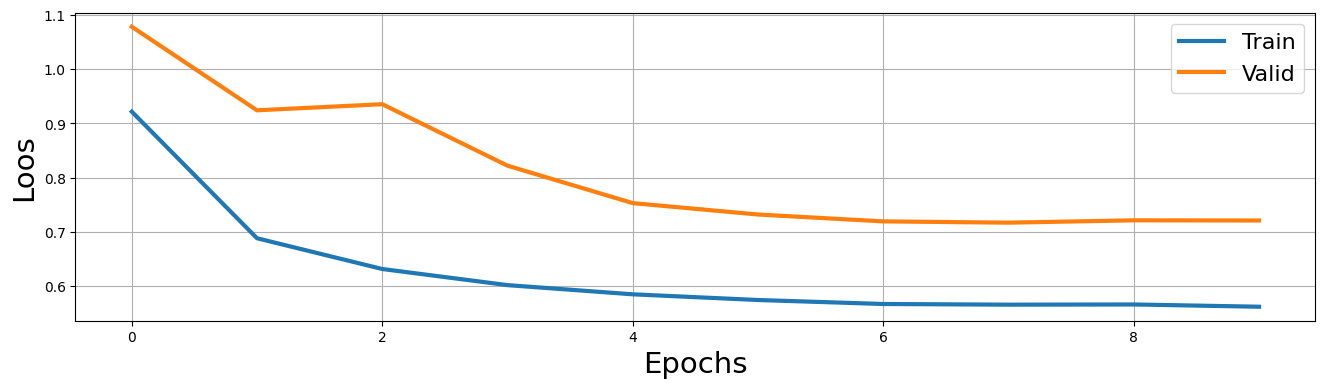

In [38]:
plt.figure(figsize=(16,4))
plt.plot([i for i in range(0, EPOCHS)], list_loos_train, lw=3, label = 'Train')
plt.plot([i for i in range(0, EPOCHS)], list_loos_valid, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Loos', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

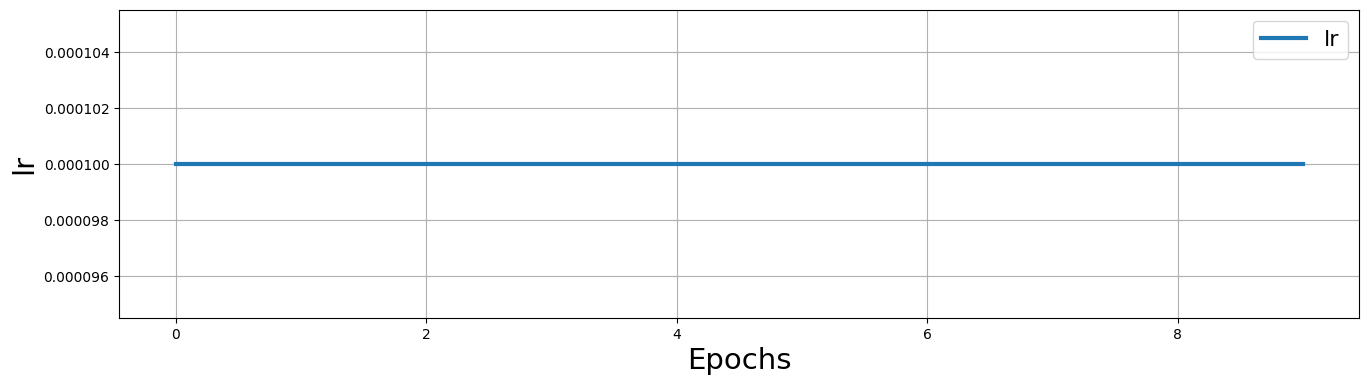

In [39]:
plt.figure(figsize=(16,4))
plt.plot([i for i in range(0, EPOCHS)], list_lr, lw=3, label = 'lr')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('lr', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

# Тестируем на тестовых данных

In [40]:
list_metric_test = []
model.eval()
running_loss = 0.
metric = METRIC
metric.to(DEVICE)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model(images)
        metric(output, labels)
        loss = criterion(output, labels)
        running_loss += loss
        
        origin = images[0].cpu().numpy().transpose(2, 1, 0)
        true = colour_code_segmentation(reverse_one_hot(
                labels[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB)
        pred = colour_code_segmentation(reverse_one_hot(
                output[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB)
        
        cv2.imwrite(os.path.join(PRED_TEST, f"sample_pred_{i}.png"), np.hstack(
            [origin, true, pred])[:, :, ::-1])

        list_metric_test.append(metric.compute().item())
        print(f'step [{i+1}/{len_steps}]')


step [1/35]
step [2/35]
step [3/35]
step [4/35]
step [5/35]
step [6/35]
step [7/35]
step [8/35]
step [9/35]
step [10/35]
step [11/35]
step [12/35]
step [13/35]
step [14/35]
step [15/35]
step [16/35]
step [17/35]
step [18/35]
step [19/35]
step [20/35]
step [21/35]
step [22/35]
step [23/35]
step [24/35]
step [25/35]
step [26/35]
step [27/35]
step [28/35]
step [29/35]
step [30/35]
step [31/35]
step [32/35]
step [33/35]
step [34/35]
step [35/35]
step [36/35]
step [37/35]
step [38/35]
step [39/35]
step [40/35]
step [41/35]
step [42/35]
step [43/35]
step [44/35]
step [45/35]
step [46/35]
step [47/35]
step [48/35]
step [49/35]


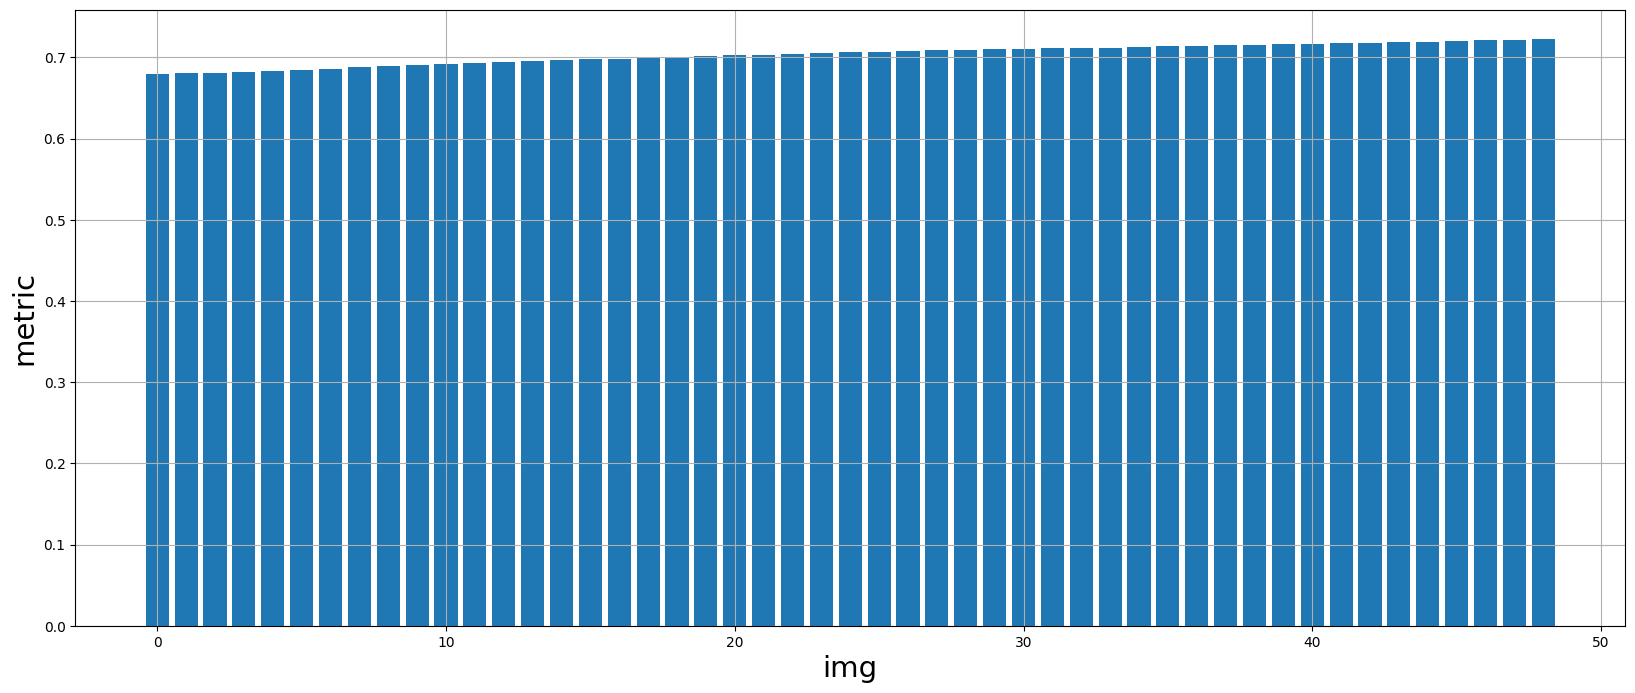

In [41]:
plt.figure(figsize=(20, 8))
plt.bar([i for i in range(0, len(list_metric_test))], list_metric_test)
plt.xlabel('img', fontsize=21)
plt.ylabel('metric', fontsize=21)
plt.grid()
plt.show()

In [42]:
torch.save(model.state_dict(), 'model_scripted.pt')